# Features derived from an limit order book

In this book we make an attempt to create features based on bids and asks in a limit orderbook.
We discuss what how the data could be processed such that machine learning models can understand certain patterns and possibly act in favour of execution optimization.

In [1]:
%cd ..

/Volumes/Data/dev/ctc-executioner


In [2]:
from ctc_executioner.orderbook import Orderbook

Attempt to load from cache.
Order book in cache. Load...


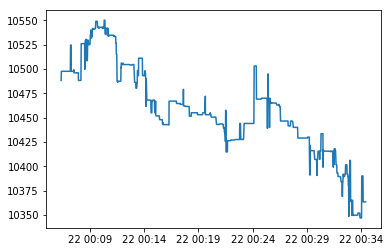

In [4]:
orderbook = Orderbook()
orderbook.loadFromEvents('data/events/ob-1-small.tsv')
orderbook.plot()

First we draw a random state (index) from the orderbook with which we have enough time remaining to proceed an execution of 120 seconds.

In [5]:
state, state_index = orderbook.getRandomState(120)
state

----------ORDERBOOK STATE----------
DateTime: 2018-02-22 00:13:36.502000
Price: 11552.0
Buyers: [10505.99999999: 0.99667609, 10480.41677178: 0.08006764, 10480.0: 0.19963397, 10453.88781134: 0.2627985, 10449.60119407: 0.00043737, 10436.00000001: 0.10316389999999999, 10436.0: 0.53499925, 10433.88: 0.555, 10428.94947031: 0.001, 10428.21602036: 0.00095894, 10423.5392: 0.08672471, 10420.03799999: 0.002, 10417.76100678: 0.33251094, 10414.57865184: 0.00046117, 10410.0: 0.1, 10409.1625365: 0.00182992, 10400.0: 4.14929957, 10396.9313723: 0.00100689, 10373.99: 0.40448772, 10364.31: 1.5102977899999999, 10360.5421125: 0.00105723, 10352.04698263: 0.00046814, 10350.0: 0.04762781, 10347.0: 1.60526415, 10335.77: 3.98, 10325.693000000001: 2.1679, 10319.09994405: 0.00111009, 10301.0: 0.08163697, 10300.0: 0.86119792, 10297.05081026: 0.01010764, 10281.13398363: 0.01672194, 10272.6639943: 0.00116559, 10255.1322809: 0.0261802, 10250.0: 5.616586659999999, 10239.90571194: 0.7771438, 10219.48498969: 0.00070326

Here the bids and asks in dictionary form.

In [6]:
d_state = orderbook.getDictState(state_index)
d_state

{'asks': {10516.0: 0.52791317,
  10519.0: 3.50416118,
  10533.54153572: 0.13,
  10548.0: 0.10712896,
  10549.99999999: 1.68,
  10550.0: 1.5542912899999999,
  10550.032: 0.01135661,
  10560.0: 0.04431027,
  10560.93874059: 0.06429247,
  10562.9: 0.521,
  10564.63780298: 1.09177311,
  10568.0: 0.52321268,
  10570.0: 0.34896438,
  10577.69374186: 0.01129165,
  10585.322944: 0.76775152,
  10598.8251: 0.6,
  10600.0: 5.62071577,
  10610.0: 0.92803765,
  10613.806: 2.1679,
  10613.97: 0.24,
  10615.07196424: 0.00045126,
  10617.0: 0.00049533,
  10622.0: 0.03,
  10632.87778385: 0.002,
  10633.0: 0.03,
  10638.57135466: 0.001,
  10640.0: 1.022,
  10644.0: 7.31309508,
  10650.0: 1.72628254,
  10655.0: 0.03,
  10655.079380700001: 0.00039076,
  10660.62285: 0.00036686,
  10666.0: 0.65467235,
  10672.0: 0.01032123,
  10680.0: 7.29737979,
  10693.5848088: 0.00068217,
  10717.0: 0.00049533,
  10720.0: 0.09922269,
  10730.0: 0.18265720000000002,
  10777.817: 1.88425,
  10792.0: 0.09999937,
  10796.00

# Private Variables

Private variables in the context of order execution is a tuple of the remaining time (seconds) and inventory (share size).

In [7]:
(120, 1.0) # 1.0 BTC left to be executed within 120 seconds

(120, 1.0)

As we can see, there is not much information to be drawn from the private variables. Hence we lay our focus on the market variables.

# Market Variables

Market variables contain information derived from the market at the time right before the execution is being placed. 

However, the fact that this is a non-stationary time series setting, one would have to 1) preprocess features either beforehand or on demand and 2) likely be forced to approximate the resulted values in order get an indication of the value relative to the values derived from other states.

An alternative approach would be to use raw inputs as market variables and in a later learning process let a funciton approximator derive relations. Thus, the following section will present a way of representing a limit order book as a matrix, acting as a raw set of features.

## Bids / Asks

In [8]:
import numpy as np
from collections import OrderedDict
import pandas as pd

In [9]:
state = orderbook.getDictState(state_index)
asks = state['asks']
bids = state['bids']
bestAsk = min(asks.keys())

We now represent the bids and asks as a numpy array in the shape of `(2, levels, count(features))`.
In case both features, price and size are enabled, the output is as follows:

```
[
    [
        [bid_price  bid_size]
        [...        ...     ]
    ]
    [
        [ask_price  ask_size]
        [...        ...     ]
    ]
]
```

If eiether price or size is choosen only, the output has the shape `(2, levels)` and is as follows:

```
[
    [
        bid_price
        ...
    ]
    [
        ask_price
        ...      
    ]
]
```

or respectively:

```
[
    [
        bid_size
        ...     
    ]
    [
        ask_size
        ...     
    ]
]
```

In [10]:
def getBidAskFeature(bids, asks, qty=None, price=True, size=True, normalize=False, levels=20):
    """Creates feature to represent bids and asks.

    The prices and sizes of the bids and asks are normalized by the provided
    (naturally current) bestAsk and the provided quantity respectively.
    
    Shape: (2, levels, count(features)), whereas features can be [price, size]
    [
        [
            [bid_price  bid_size]
            [...        ...     ]
        ]
        [
            [ask_price  ask_size]
            [...        ...     ]
        ]
    ]
      
    """
    assert(price is True or size is True)
    
    def toArray(d):
        s = pd.Series(d, name='size')
        s.index.name='price'
        s = s.reset_index()
        return np.array(s)

    def force_levels(a, n=levels):
        """Shrinks or expands array to n number of records."""
        gap = (n - a.shape[0])
        if gap > 0:
            gapfill = np.zeros((gap, 2))
            a = np.vstack((a, gapfill))
            return a
        elif gap <= 0:
            return a[:n]

    bids = OrderedDict(sorted(bids.items(), reverse=True))
    asks = OrderedDict(sorted(asks.items()))
    bids = toArray(bids)
    asks = toArray(asks)
    if normalize is True:
        assert(qty is not None)
        bestAsk = np.min(asks[:,0])
        bids = np.column_stack((bids[:,0] / bestAsk, bids[:,1] / qty))
        asks = np.column_stack((asks[:,0] / bestAsk, asks[:,1] / qty))

    bidsAsks = np.array([force_levels(bids), force_levels(asks)])    
    if price is True and size is True:
        return bidsAsks
    if price is True:
        return bidsAsks[:,:,0]
    if size is True:
        return bidsAsks[:,:,1]


In [11]:
feature_ba = getBidAskFeature(d_state['bids'], d_state['asks'], qty=1.0, normalize=True, price=True, size=True, levels = 10)
print(feature_ba.shape)
print(feature_ba)

(2, 10, 2)
[[[9.99049068e-01 9.96676090e-01]
  [9.96616277e-01 8.00676400e-02]
  [9.96576645e-01 1.99633970e-01]
  [9.94093554e-01 2.62798500e-01]
  [9.93685926e-01 4.37370000e-04]
  [9.92392545e-01 1.03163900e-01]
  [9.92392545e-01 5.34999250e-01]
  [9.92190947e-01 5.55000000e-01]
  [9.91722087e-01 1.00000000e-03]
  [9.91652341e-01 9.58940000e-04]]

 [[1.00000000e+00 5.27913170e-01]
  [1.00028528e+00 3.50416118e+00]
  [1.00166808e+00 1.30000000e-01]
  [1.00304298e+00 1.07128960e-01]
  [1.00323317e+00 1.68000000e+00]
  [1.00323317e+00 1.55429129e+00]
  [1.00323621e+00 1.13566100e-02]
  [1.00418410e+00 4.43102700e-02]
  [1.00427337e+00 6.42924700e-02]
  [1.00445987e+00 5.21000000e-01]]]


In [12]:
feature_ba = getBidAskFeature(d_state['bids'], d_state['asks'], qty=1.0, normalize=True, price=True, size=False, levels = 5)
print(feature_ba)

[[0.99904907 0.99661628 0.99657665 0.99409355 0.99368593]
 [1.         1.00028528 1.00166808 1.00304298 1.00323317]]


Given the function `getBidAskFeature` with which we can represent the order book state as a numpy array, we now want to combine a certain number of states into one data structure.
Hence, a `lookback` is defined which tells how many states in the past (relative to the `state_index`) shall be considered.

The output of this funciton

In [13]:
def getBidAskFeatures(d, state_index, lookback, qty=None, price=True, size=True, normalize=False, levels=20):
    """ Creates feature to represent bids and asks with a lookback of previous states.
    
    Shape: (2*lookback, levels, count(features))
    """
    state = d[list(d.keys())[state_index]]
    asks = state['asks']
    bids = state['bids']
    bestAsk = min(asks.keys())
    i = 0
    while i < lookback:
        state_index = state_index - 1
        state = d[list(d.keys())[state_index]]
        asks = state['asks']
        bids = state['bids']
        features_next = getBidAskFeature(
                            bids=bids, 
                            asks=asks, 
                            qty=qty, 
                            price=price, 
                            size=size, 
                            normalize=normalize, 
                            levels=levels
                        )
        if i == 0:
            features = features_next
        else:
            features = np.vstack((features, features_next))
        i = i + 1
    return features

In [14]:
features = getBidAskFeatures(orderbook.dictBook, state_index, lookback=3, qty=1.0, normalize=True, price=True, size=True, levels = 5)
features

array([[[9.99049068e-01, 9.96676090e-01],
        [9.96616277e-01, 8.00676400e-02],
        [9.96576645e-01, 1.99633970e-01],
        [9.94093554e-01, 2.62798500e-01],
        [9.93685926e-01, 4.37370000e-04]],

       [[1.00000000e+00, 5.27913170e-01],
        [1.00028528e+00, 3.50416118e+00],
        [1.00166808e+00, 1.30000000e-01],
        [1.00304298e+00, 1.07128960e-01],
        [1.00323317e+00, 1.68000000e+00]],

       [[9.99049068e-01, 9.96676090e-01],
        [9.96616277e-01, 8.00676400e-02],
        [9.96576645e-01, 1.99633970e-01],
        [9.94093554e-01, 2.62798500e-01],
        [9.93685926e-01, 4.37370000e-04]],

       [[1.00000000e+00, 5.27913170e-01],
        [1.00028528e+00, 3.50416118e+00],
        [1.00166808e+00, 1.30000000e-01],
        [1.00304298e+00, 1.07128960e-01],
        [1.00323317e+00, 1.68000000e+00]],

       [[9.99049068e-01, 9.96676090e-01],
        [9.96616277e-01, 8.00676400e-02],
        [9.96576645e-01, 1.99633970e-01],
        [9.94093554e-01, 2

As we can see, the bids and asks are currently threated separately.
As the orderbook comes natural with both sides, which are already ordered such that best-bid and best-ask are in the middle, we can combine the sides and shrink the number of features by half and instead merge the second dimension.
Hence the shaps is: `(lookback, 2*levels, count(features))`

In [15]:
features_combined = features.reshape((int(features.shape[0]/2), features.shape[1]*2, features.shape[2]))
print(features_combined.shape)
features_combined

(3, 10, 2)


array([[[9.99049068e-01, 9.96676090e-01],
        [9.96616277e-01, 8.00676400e-02],
        [9.96576645e-01, 1.99633970e-01],
        [9.94093554e-01, 2.62798500e-01],
        [9.93685926e-01, 4.37370000e-04],
        [1.00000000e+00, 5.27913170e-01],
        [1.00028528e+00, 3.50416118e+00],
        [1.00166808e+00, 1.30000000e-01],
        [1.00304298e+00, 1.07128960e-01],
        [1.00323317e+00, 1.68000000e+00]],

       [[9.99049068e-01, 9.96676090e-01],
        [9.96616277e-01, 8.00676400e-02],
        [9.96576645e-01, 1.99633970e-01],
        [9.94093554e-01, 2.62798500e-01],
        [9.93685926e-01, 4.37370000e-04],
        [1.00000000e+00, 5.27913170e-01],
        [1.00028528e+00, 3.50416118e+00],
        [1.00166808e+00, 1.30000000e-01],
        [1.00304298e+00, 1.07128960e-01],
        [1.00323317e+00, 1.68000000e+00]],

       [[9.99049068e-01, 9.96676090e-01],
        [9.96616277e-01, 8.00676400e-02],
        [9.96576645e-01, 1.99633970e-01],
        [9.94093554e-01, 2.627

**Note:** The demonstrated features has been integrated in the Orderbook class and can be used directly:

In [16]:
orderbook.getBidAskFeatures(state_index, lookback=3, qty=1.0, normalize=True, price=True, size=True, levels = 5)

array([[[9.99049068e-01, 9.96676090e-01],
        [9.96616277e-01, 8.00676400e-02],
        [9.96576645e-01, 1.99633970e-01],
        [9.94093554e-01, 2.62798500e-01],
        [9.93685926e-01, 4.37370000e-04]],

       [[1.00000000e+00, 5.27913170e-01],
        [1.00028528e+00, 3.50416118e+00],
        [1.00166808e+00, 1.30000000e-01],
        [1.00304298e+00, 1.07128960e-01],
        [1.00323317e+00, 1.68000000e+00]],

       [[9.99049068e-01, 9.96676090e-01],
        [9.96616277e-01, 8.00676400e-02],
        [9.96576645e-01, 1.99633970e-01],
        [9.94093554e-01, 2.62798500e-01],
        [9.93685926e-01, 4.37370000e-04]],

       [[1.00000000e+00, 5.27913170e-01],
        [1.00028528e+00, 3.50416118e+00],
        [1.00166808e+00, 1.30000000e-01],
        [1.00304298e+00, 1.07128960e-01],
        [1.00323317e+00, 1.68000000e+00]],

       [[9.99049068e-01, 9.96676090e-01],
        [9.96616277e-01, 8.00676400e-02],
        [9.96576645e-01, 1.99633970e-01],
        [9.94093554e-01, 2

## Correlation of order book states

We now want to make a statement about the correlation of the previous states in order to determiene what an appropriate lookback might be.

At first, however, let us understand how many states occur per second and what the change of price in dollar is per second.

In [17]:
orderbook.summary()

Number of states: 1132
Duration: 1681.814
States per second: 0.6730827546922549
Change of price per second: 4.429090910743369


After having a brief understanding of the states the order book contains, we go further and take a random state and determine the pearson correlations of the prices and sizes from the previous n states.
This shall provide an intuition of how much information is provided by previous order book states. 

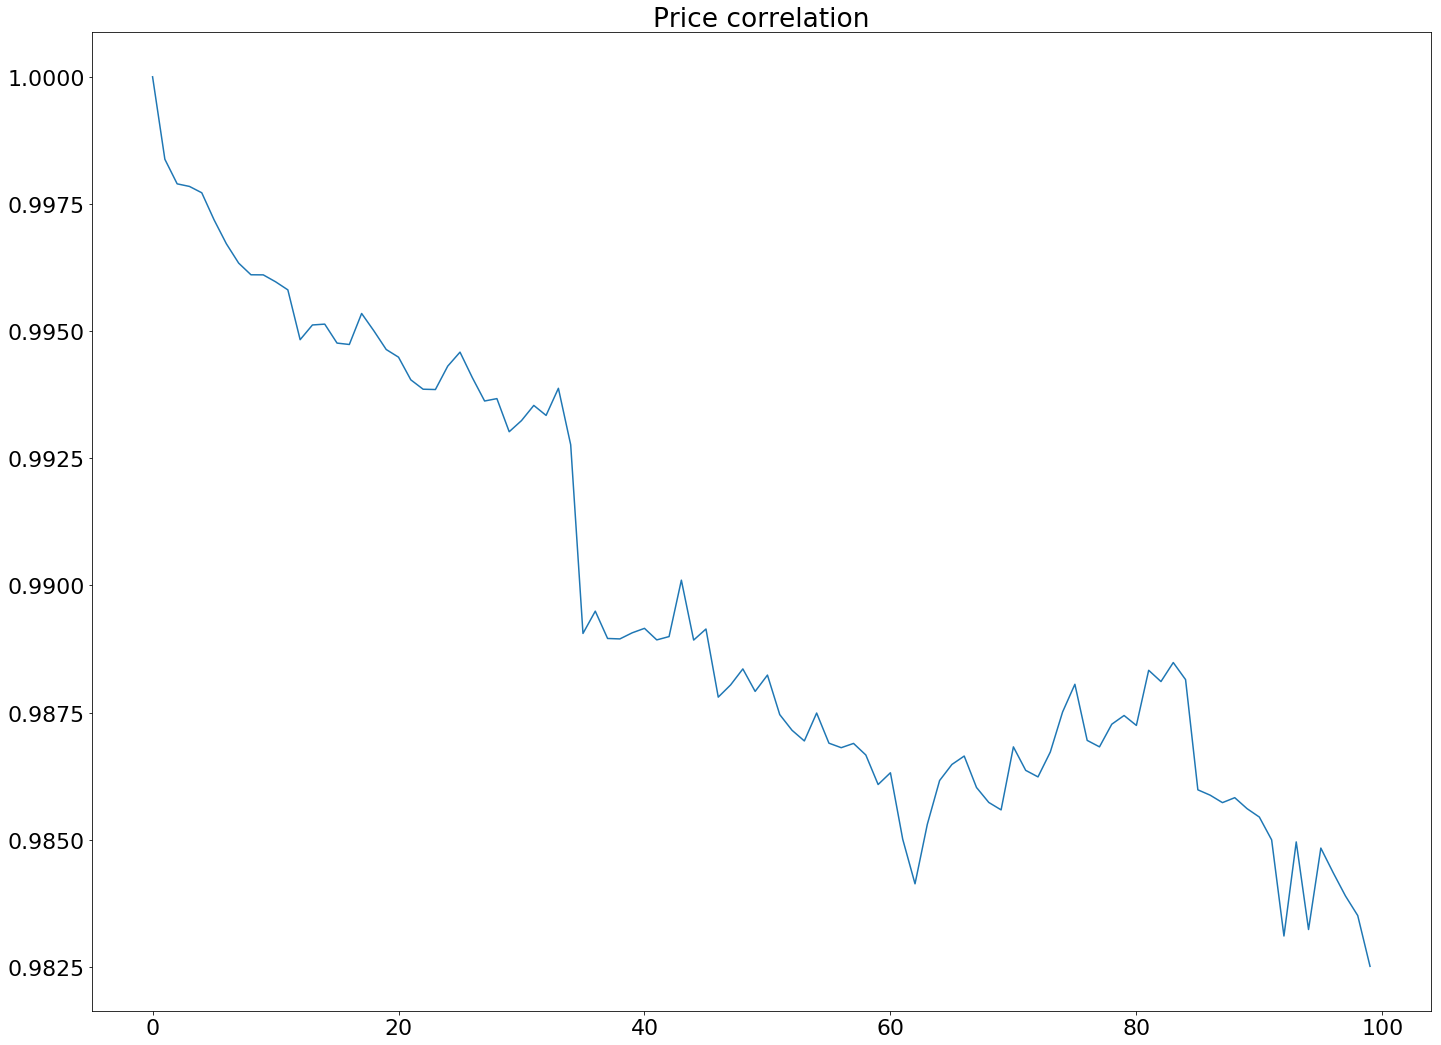

In [90]:
import scipy as sp

lookback = 100
lookback_range = range(lookback)
prices = []
sizes = []

for _ in range(10):
    state, state_index = orderbook.getRandomState(runtime=120, min_head=lookback)
    features = orderbook.getBidAskFeatures(state_index, lookback=lookback, qty=1.0, normalize=False, levels = 20)
    bidsasks = features.reshape((int(features.shape[0]/2), features.shape[1]*2, features.shape[2]))

    arr_price = []
    for i in lookback_range:
        corr, p = sp.stats.pearsonr(bidsasks[0,:,0], bidsasks[i,:,0])
        arr_price.append(corr)
    prices.append(arr_price)

    arr_size = []
    for i in lookback_range:
        corr, p = sp.stats.pearsonr(bidsasks[0,:,1], bidsasks[i,:,1])
        arr_size.append(corr)
    sizes.append(arr_size)


prices_mean = np.mean(np.array(prices), axis=0)
sizes_mean = np.mean(np.array(sizes), axis=0)


import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(24, 18))
plt.title("Price correlation")
plt.plot(lookback_range, prices_mean)
plt.show()




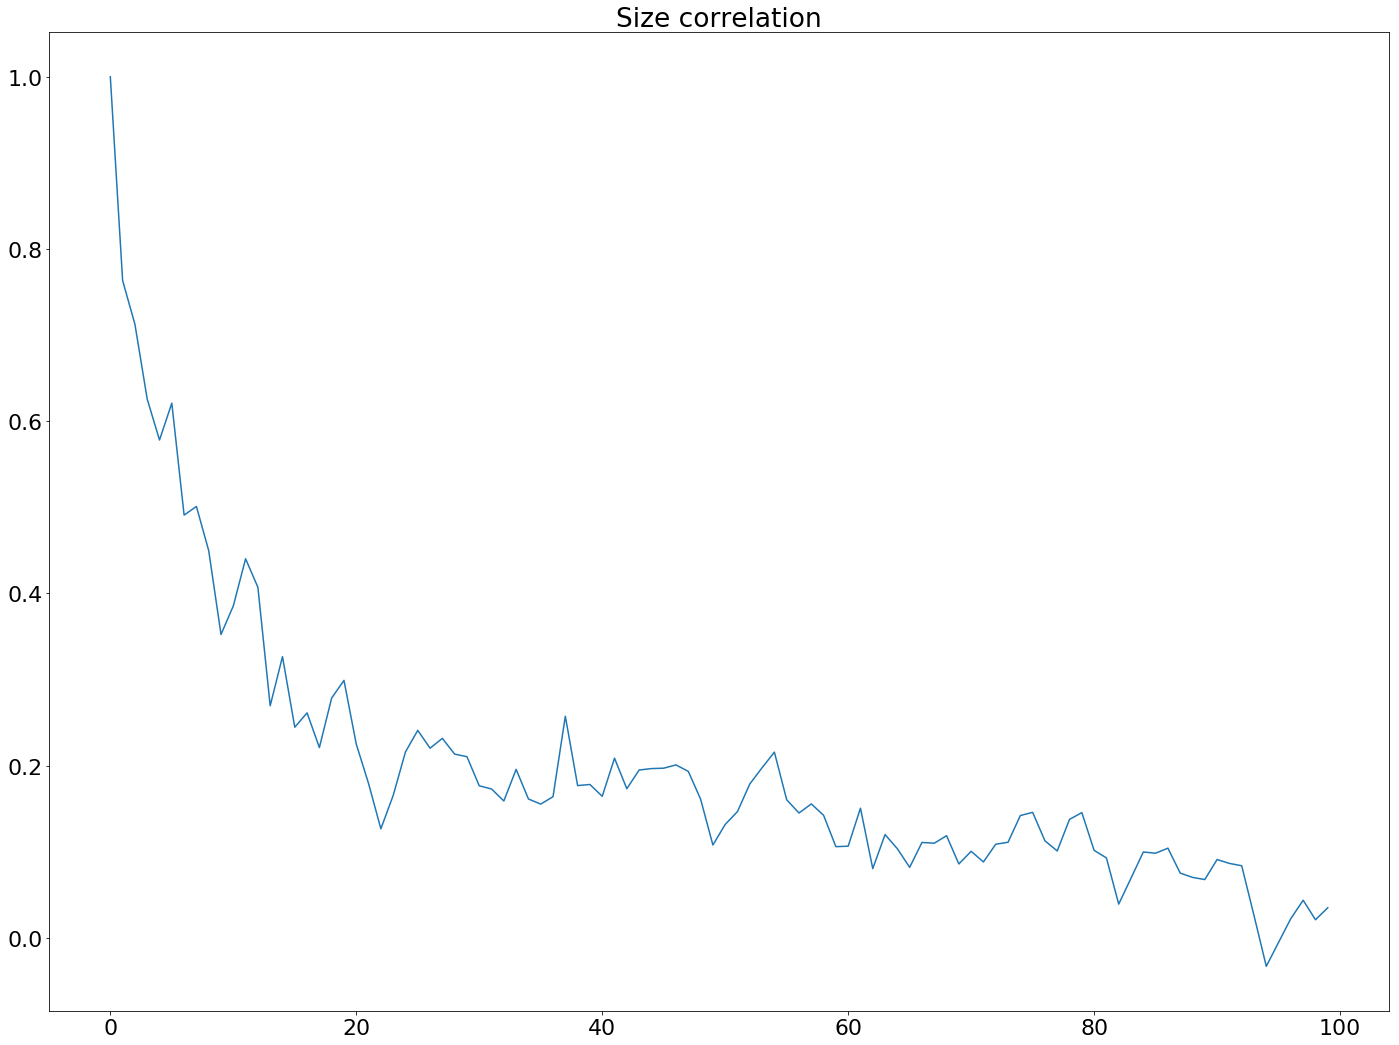

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 18))
plt.title("Size correlation")

plt.plot(lookback_range, sizes_mean)
plt.show()

As we can see, price constellations in order books correlate much more than the sizes.
Furthermore, the correlation of the price positions remain more or less constant, followed by a signigicant drop after a few states into the past. The size correlation however drops immediately.
Given the high correlation of prices, a *lookback* of >40 states is suggested.

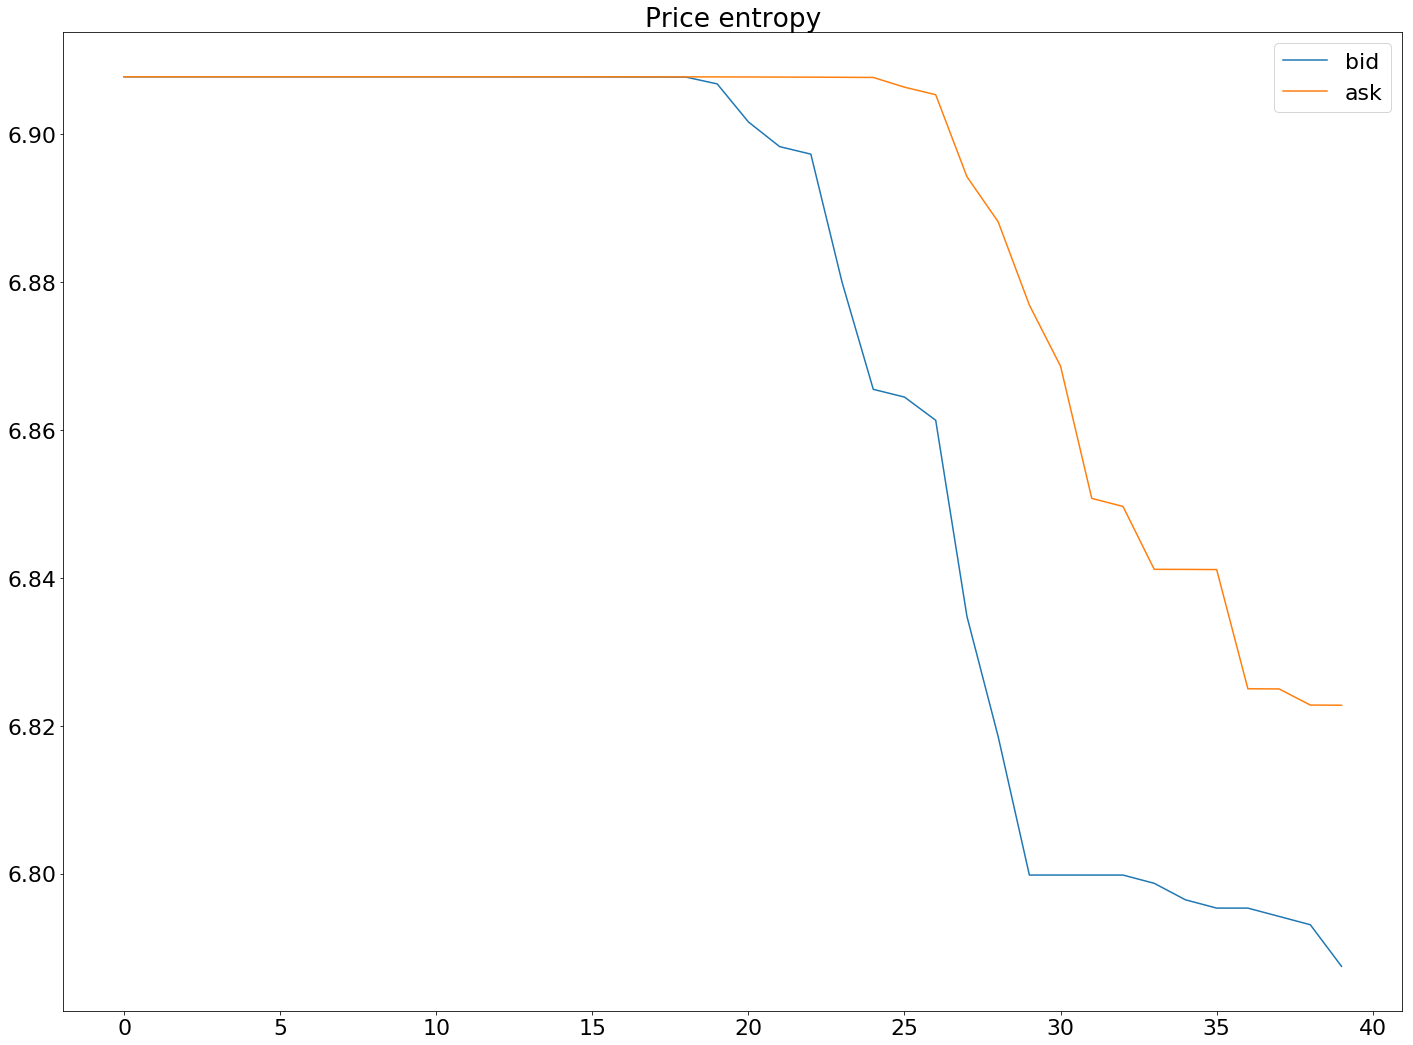

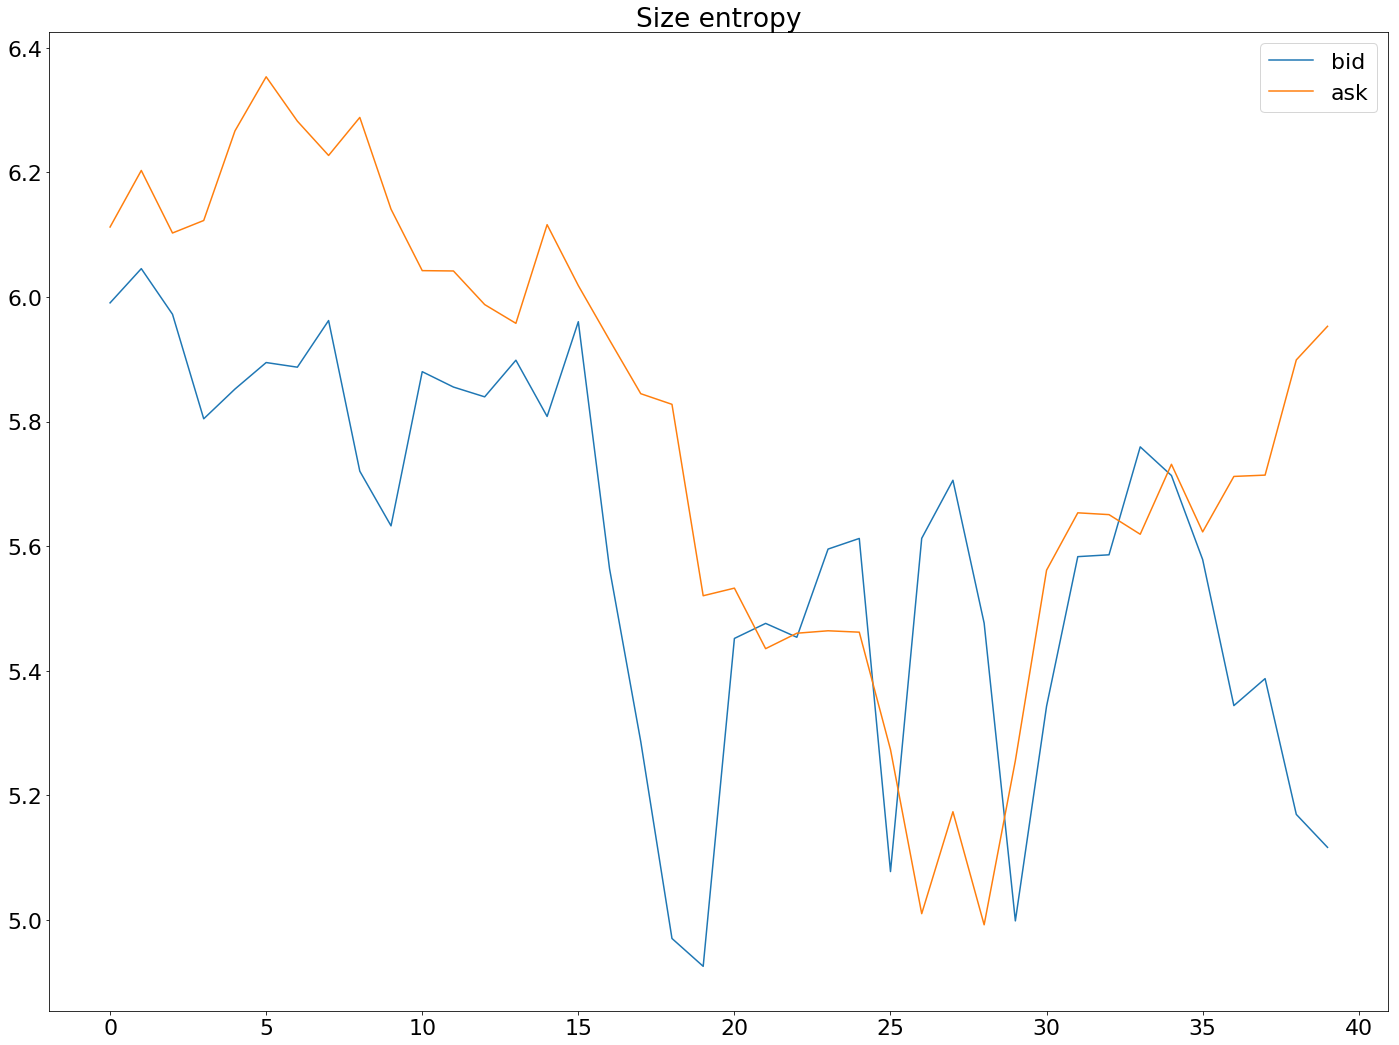

In [92]:
import scipy as sp

lookback = 1000
lookback_range = range(lookback)
p_bids = []
p_asks = []
s_bids = []
s_asks = []

for _ in range(10):
    state, state_index = orderbook.getRandomState(runtime=120, min_head=lookback)
    features = orderbook.getBidAskFeatures(state_index, lookback=lookback, qty=1.0, normalize=False, levels = 40)
    bidsasks = features.reshape((int(features.shape[0]), features.shape[1], features.shape[2]))
    bids = bidsasks[::2,:,:]
    asks = bidsasks[1::2,:,:]
    
    p_bid = bids[:,:,0]
    p_ask = asks[:,:,0]
    s_bid = bids[:,:,1]
    s_ask = asks[:,:,1]

    p_bids.append(sp.stats.entropy(p_bid))
    p_asks.append(sp.stats.entropy(p_ask))
    s_bids.append(sp.stats.entropy(s_bid))
    s_asks.append(sp.stats.entropy(s_ask))

p_bids_mean = np.mean(np.array(p_bids), axis=0)
p_asks_mean = np.mean(np.array(p_asks), axis=0)
s_bids_mean = np.mean(np.array(s_bids), axis=0)
s_asks_mean = np.mean(np.array(s_asks), axis=0)

import matplotlib.pyplot as plt
plt.figure(figsize=(24, 18))
plt.title("Price entropy")
plt.plot(p_bids_mean, label='bid')
plt.plot(p_asks_mean, label='ask')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
plt.figure(figsize=(24, 18))
plt.title("Size entropy")
plt.plot(s_bids_mean, label='bid')
plt.plot(s_asks_mean, label='ask')
plt.legend()
plt.show()


We take 1000 random order book states for which we measure the entropy for a range of 40 limit levels on the bid and ask side, applied to price (see Figure 1) and size (see Figure 2).
It is noticable that the entropy remains high regarding the pices for for limit levels 0-30 on both, bid and ask side.
The price becomes slightly more constant for limit levels >30.
The entropy for order sizes drop after 20 limit levels, which means that the accumulated order size deep in the book is more constant.
We therefore suggest to consider at least 30 limit levels of the bid-ask feature.

# Conclusion

This analysis provides an example on how to model a limit order book as a matrix. We further show how to incorporate multiple order book states from the past into the order book matrix and thereby define the number of steps to include as *lookback*.
By briefly highlighting the sparse amount of *private variables* (2) and their purpose we ensure the reader understands the importance of *market variables*. Thereby we highlight the difficulties of creating features within a time series setting and suggest to use raw features. A raw feature set is being derived from the order book and is demonstrated as the mentioned order book matrix.
To get an understanding on the correlation of the prices and sized contained in a set of order book states, we draw the pearson correlation and conclude that prices are much more related among order book states than the offered sizes.